In [255]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 20), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns 
import tensorflow as tf
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import keras.backend as K



from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


<Figure size 2400x1600 with 0 Axes>

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
dir_name="/home/aniket/Music/notebooks/data/m5-forecasting-uncertainty"
data_folder = Path(dir_name)

In [4]:
calender_data = pd.read_csv(data_folder/"calendar.csv")

In [5]:
sales_data = pd.read_csv(data_folder/"sales_train_validation.csv")
sell_prices_data = pd.read_csv(data_folder/"sell_prices.csv")

In [6]:
calender_data.tail()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [7]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [8]:
sell_prices_data

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [115]:
prediction_columns = [col for col in sales_data.columns if 'd_' in col]

In [126]:
sales_data_hobbies.mean(0)

d_1       0.666195
d_2       0.594159
d_3       0.474690
d_4       0.472389
d_5       0.321062
            ...   
d_1909    0.614513
d_1910    0.593451
d_1911    0.723009
d_1912    0.847257
d_1913    0.828850
Length: 1913, dtype: float64

In [127]:
sales_data_hobbies = sales_data[sales_data['cat_id']=='HOBBIES'][prediction_columns]

In [163]:
sales_data_hobbies.iloc[1]

d_1       0
d_2       0
d_3       0
d_4       0
d_5       0
         ..
d_1909    1
d_1910    0
d_1911    0
d_1912    0
d_1913    0
Name: 1, Length: 1913, dtype: int64

In [128]:
sales_data_hobbies_std = sales_data_hobbies.sub(sales_data_hobbies.mean(0),axis=1).div(sales_data_hobbies.std(0), axis=1)

In [135]:
sales_data_hobbies_std

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.183634,0.993519,-0.332950,0.210300,0.167724,0.213695,1.280742,-0.354442,0.070831,0.079421
1,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,0.213695,-0.315829,-0.354442,-0.392896,-0.384621
2,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.740251,0.081960,0.447617,0.210300,0.167724,0.213695,-0.315829,0.135790,0.070831,0.079421
3,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.183634,-0.373820,1.618468,1.742133,0.167724,-0.340656,0.216361,1.116252,2.853194,0.543463
4,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.740251,0.081960,0.057334,-0.300312,0.167724,0.213695,0.748552,0.626021,0.534558,1.471548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28001,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,-0.340656,1.812933,-0.354442,-0.392896,-0.384621
28002,-0.23891,0.582039,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,-0.340656,-0.315829,-0.354442,-0.392896,-0.384621
28003,-0.23891,-0.245991,-0.204825,-0.226332,-0.193577,-0.209458,-0.206058,-0.233463,-0.247985,-0.197495,...,0.183634,-0.373820,-0.332950,-0.300312,-0.340941,0.768045,-0.315829,0.135790,0.534558,-0.384621
28004,-0.23891,-0.245991,-0.204825,0.252790,-0.193577,-0.209458,-0.206058,0.097462,-0.247985,-0.197495,...,-0.372982,-0.373820,-0.332950,-0.300312,-0.340941,-0.340656,-0.315829,-0.354442,-0.392896,-0.384621


In [118]:
x_axis_range  = np.tile(range(0,sales_data_hobbies.shape[1]),(sales_data_hobbies.shape[1],1))

In [119]:
sales_data_hobbies.iloc[0]

d_1       0
d_2       0
d_3       0
d_4       0
d_5       0
         ..
d_1909    1
d_1910    3
d_1911    0
d_1912    1
d_1913    1
Name: 0, Length: 1913, dtype: int64

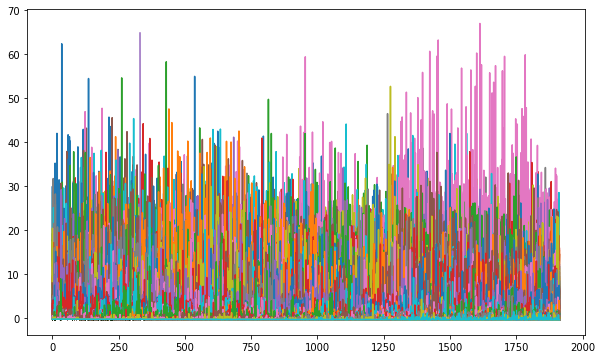

In [136]:
for i in range(0,sales_data_hobbies_std.shape[0]):
    plt.plot(range(0,sales_data_hobbies_std.shape[1]),sales_data_hobbies_std.iloc[i])

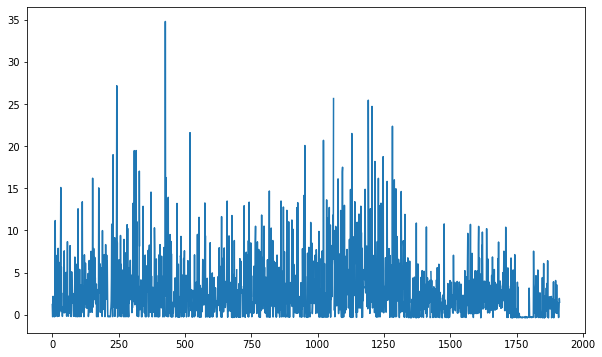

In [178]:
plt.plot(range(0,sales_data_hobbies.shape[1]),sales_data_hobbies_std.iloc[14])

#### sales_data_hobbies_std.iloc[0]

In [121]:
plt.savefig('hobbies.png')

<Figure size 720x432 with 0 Axes>

In [179]:
sales_data.iloc[14]

id          HOBBIES_1_015_CA_1_validation
item_id                     HOBBIES_1_015
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_1
                        ...              
d_1909                                  0
d_1910                                  0
d_1911                                  2
d_1912                                  5
d_1913                                  4
Name: 14, Length: 1919, dtype: object

# EDA

## Analysis for same item in different stores and states

In [10]:
def get_prediction(sales_data,item_id,store_id):
    prediction_columns = [col for col in sales_data.columns if 'd_' in col]
    data = sales_data.loc[(sales_data['item_id']==item_id) & (sales_data['store_id']==store_id)]
    return data[prediction_columns].values.flatten()

In [11]:
HOBBIES_1_001_CA_1_validation_pred = get_prediction(sales_data,'HOBBIES_1_001','CA_1')
HOBBIES_1_001_CA_2_validation_pred = get_prediction(sales_data,'HOBBIES_1_001','CA_2')
HOBBIES_1_001_CA_3_validation_pred = get_prediction(sales_data,'HOBBIES_1_001','CA_3')

In [12]:
corr = np.corrcoef(HOBBIES_1_001_CA_1_validation_pred,HOBBIES_1_001_CA_2_validation_pred)

In [13]:
corr

array([[1.        , 0.19255759],
       [0.19255759, 1.        ]])

In [15]:
prediction_data = sales_data[prediction_columns]

corrmat = prediction_data.corr()

heat_map = sns.heatmap(corrmat)

In [16]:
calender_data['is_event'] = calender_data[['event_name_1','event_name_2']].apply(lambda x : 0 if(pd.isna(x['event_name_1']) & pd.isna(x['event_name_2']) ) else 1,axis=1)

In [17]:
calender_data.event_name_1.value_counts()

NBAFinalsStart         6
Purim End              6
NBAFinalsEnd           6
MemorialDay            6
Pesach End             6
StPatricksDay          6
LentWeek2              6
ValentinesDay          6
LentStart              6
Mother's day           6
PresidentsDay          6
Ramadan starts         6
SuperBowl              6
VeteransDay            5
OrthodoxChristmas      5
Easter                 5
MartinLutherKingDay    5
NewYear                5
Christmas              5
IndependenceDay        5
EidAlAdha              5
Chanukah End           5
Cinco De Mayo          5
Thanksgiving           5
LaborDay               5
Eid al-Fitr            5
Halloween              5
ColumbusDay            5
OrthodoxEaster         5
Father's day           4
Name: event_name_1, dtype: int64

In [18]:
p1 = prediction_data.iloc[0,:]
p2 = prediction_data.iloc[2,:]

p1 = (p1-p1.mean())/p1.std()
p2 = (p2-p2.mean())/p2.std()

np.linalg.norm(p1-p2)

56.21507647565369

In [19]:
eucledian_matrix = np.zeros([len(prediction_data),len(prediction_data)])

for i in range(0,len(prediction_data)-1):
    for j in range(i+1,len(prediction_data)):
        p1 = prediction_data.iloc[i,:]
        p2 = prediction_data.iloc[j,:]
        p1 = (p1-p1.mean())/p1.std()
        p2 = (p2-p2.mean())/p2.std()
        eucledian_matrix[i][j] = np.linalg.norm(p1-p2)
    

eucledian_matrix.dump(dir_name/"eucledian_matrix.dat")

eucledian_matrix = np.zeros([len(prediction_data)])
for j in range(0,len(prediction_data)):
        p1 = prediction_data.iloc[0,:]
        p2 = prediction_data.iloc[j,:]
        p1 = (p1-p1.mean())/p1.std()
        p2 = (p2-p2.mean())/p2.std()
        eucledian_matrix[j] = np.linalg.norm(p1-p2)



eucledian_matrix

eucledian_matrix[0] = 1000

np.argmin(eucledian_matrix,axis=0)

In [21]:
prediction_data

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
30487,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0
30488,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [22]:
np.sqrt(np.sum(np.square(p1.values - p2.values)))

56.21507647565369

In [23]:
p1 = prediction_data.iloc[0,:]
p1_rolling_mean = p1.rolling(window=20).mean()

([<matplotlib.axis.XTick at 0x7fd076627650>,
 <a list of 10 Text xticklabel objects>)

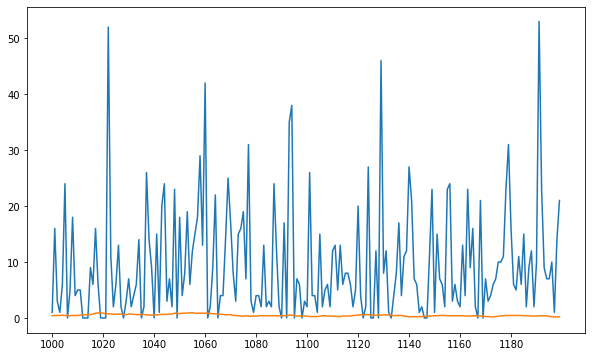

In [180]:
#plt.plot(range(800,1913),HOBBIES_1_001_CA_1_validation_pred[800 :])
#plt.plot(range(800,1913),HOBBIES_1_001_CA_2_validation_pred[800 :])
plt.plot(range(1000 ,1200),get_prediction(sales_data,'HOBBIES_1_015','CA_1')[1000 :1200])
plt.plot(range(1000 ,1200),p1_rolling_mean[1000 :1200])
#plt.plot(range(1000 ,1400),calender_data['is_event'][1000 : 1400])
plt.xticks(np.arange(1000 ,1200,20))

In [25]:
p1.transpose()

d_1       0
d_2       0
d_3       0
d_4       0
d_5       0
         ..
d_1909    1
d_1910    3
d_1911    0
d_1912    1
d_1913    1
Name: 0, Length: 1913, dtype: int64

# Data Preparation

In [224]:
history_size=7

In [225]:
categorical_features = ['event_name_1']
categorical_transformer = Pipeline(steps=[
       ("Imputer2", SimpleImputer(missing_values=np.nan, strategy='constant')),
                        ("Encoding", OneHotEncoder())
                        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

In [226]:
calender_data_transform = preprocessor.fit_transform(calender_data[categorical_features])

In [227]:
calender_data_transform = calender_data_transform.todense()

In [228]:
calender_data_transform[1]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [229]:
event_one_hot_shape = calender_data_transform.shape[1]

In [230]:
shape = (history_size+2,1)

In [231]:
def get_data(dataset,history_size,shape,item_name):
    data=[]
    label=[]
    dataset_size = len(dataset)
    for i in reversed(range(history_size,dataset_size-1)):
        x = dataset[i-history_size:i]
        x = np.append(x,calender_data[['wday','month']].iloc[i].values)
        current_wk = calender_data[['wday']].iloc[i]
        current_price = sell_prices_data[]
        x = np.append(x,)
        # x = np.append(x,calender_data_transform[i])
        y = dataset[i]
        data.append(x.reshape(shape))
        label.append(y)
    return np.array(data),np.array(label)

In [ ]:
sell_prices_data[sell_prices_data['w']]

In [232]:
p1 = prediction_data.iloc[14,:]

In [233]:
train_data = p1[0:1800].values

In [234]:
train_x,train_y = get_data(train_data,history_size,shape,item_name)

In [235]:
test_data = p1[1800:1900].values

In [236]:
test_x,test_y = get_data(test_data,history_size,shape)

# RNN

In [ ]:
for epoch in range(epochs):
   # Split data to batches
   for idx in range(0, data.shape[0], batch_size):
        batch_data = data[idx : min(idx + batch_size, data.shape[0]),:]
        batch_labels = labels[idx : min(idx + batch_size, labels.shape[0]),:]
        feed_dict = {x: batch_data,
                         y: batch_labels}
        _, c_loss = sess.run([train_step, combined_loss], feed_dict)

In [237]:
simple_lstm_model = keras.Sequential()
simple_lstm_model.add(keras.layers.LSTM(
  units=128,
input_shape=shape
))
simple_lstm_model.add(keras.layers.Dense(units=1))
simple_lstm_model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)
simple_lstm_model.fit(train_x,train_y,epochs=5)
pred_y = simple_lstm_model.predict(test_x)
plt.plot(range(0 ,pred_y.shape[0]),pred_y)
plt.plot(range(0 ,test_y.shape[0]),test_y)

In [252]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [253]:
def rnn_model():
    simple_lstm_model = keras.Sequential()
    simple_lstm_model.add(keras.layers.LSTM(
      units=128,
    input_shape=shape
    ))
    simple_lstm_model.add(keras.layers.Dense(units=1))
    
    return simple_lstm_model

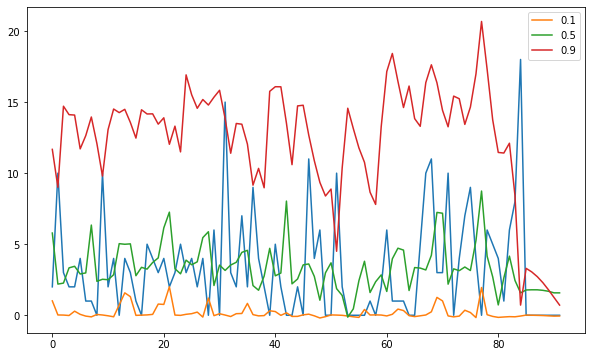

In [264]:
qs = [0.1, 0.5, 0.9]
plt.plot(range(0 ,test_y.shape[0]),test_y)
for q in qs:
    model = rnn_model()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f),  optimizer=keras.optimizers.Adam(0.001))
    model.fit(train_x,train_y, epochs=25, batch_size=8, verbose=0)
    
    # Predict the quantile
    y_pred = model.predict(test_x)
    plt.plot(range(0 ,test_y.shape[0]), y_pred, label=q) # plot out this quantile

plt.legend()    
plt.show()

In [43]:
train_y.mean()

0.2757847533632287

In [44]:
test_y.mean()

0.9642857142857143

In [45]:
pred_y.mean()

0.267132

In [46]:
simple_lstm_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'batch_input_shape': (None, 48, 1),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 8,
    'activation': 'tanh',
    'recurrent_activation': 'hard_sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None, 'dtype': 'float32'}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None, 'dtype': 'float32'}},
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constrai

# SVM

In [47]:
#clf = svm.SVR() 
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [48]:
train_x.shape

(1784, 48, 1)

In [49]:
train_x_svm = np.squeeze(train_x)

In [50]:
clf.fit(train_x_svm,train_y)

/home/aniket/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [51]:
y_pred_svr = clf.predict(np.squeeze(test_x))

In [52]:
test_y.mean()

0.9642857142857143

In [53]:
y_pred_svr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

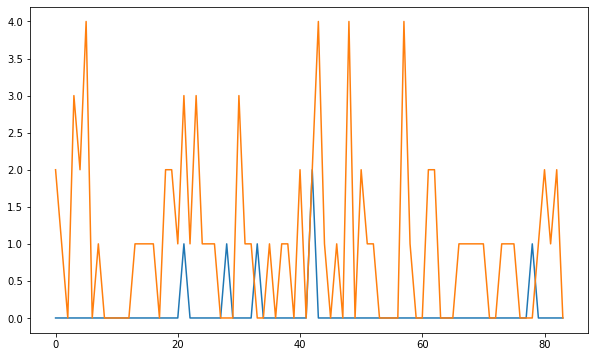

In [54]:
plt.plot(range(0 ,y_pred_svr.shape[0]),y_pred_svr)
plt.plot(range(0 ,test_y.shape[0]),test_y)

In [55]:
p1.value_counts

<bound method IndexOpsMixin.value_counts of d_1       0
d_2       0
d_3       0
d_4       0
d_5       0
         ..
d_1909    1
d_1910    3
d_1911    0
d_1912    1
d_1913    1
Name: 0, Length: 1913, dtype: int64>

In [56]:
np.unique(train_y,return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([1428,  250,   82,   19,    4,    1]))

In [57]:
p1.mean()

0.31364349189754315

In [58]:
p1= p1.reset_index()

In [59]:
p1_is_event = p1.loc[calender_data[0:1913]['is_event']!=0]

In [60]:
c = calender_data[0:1913]['is_event']!=0

In [61]:
p1_is_event.shape

(154, 2)

In [62]:
p1_is_event[0].mean()

0.2727272727272727

In [63]:
p1_peak_days = calender_data[0:p1.shape[0]].loc[p1[0]>1]

In [64]:
p1_group_week_day = p1_peak_days.groupby('weekday')

In [65]:
p1_group_week_day.count()

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event
weekday,,,,,,,,,,,,,,
Friday,17,17,17,17,17,17,1,1,0,0,17,17,17,17
Monday,15,15,15,15,15,15,3,3,0,0,15,15,15,15
Saturday,32,32,32,32,32,32,2,2,0,0,32,32,32,32
Sunday,21,21,21,21,21,21,2,2,1,1,21,21,21,21
Thursday,12,12,12,12,12,12,1,1,0,0,12,12,12,12
Tuesday,19,19,19,19,19,19,0,0,0,0,19,19,19,19
Wednesday,14,14,14,14,14,14,1,1,0,0,14,14,14,14


In [66]:
p1_peak_days

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event
916,2013-08-02,11327,Friday,7,8,2013,d_917,NaN,NaN,NaN,NaN,1,0,1,0
926,2013-08-12,11329,Monday,3,8,2013,d_927,NaN,NaN,NaN,NaN,0,1,1,0
947,2013-09-02,11332,Monday,3,9,2013,d_948,LaborDay,National,NaN,NaN,1,0,1,1
952,2013-09-07,11333,Saturday,1,9,2013,d_953,NaN,NaN,NaN,NaN,1,1,0,0
965,2013-09-20,11334,Friday,7,9,2013,d_966,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,2016-04-06,11610,Wednesday,5,4,2016,d_1895,NaN,NaN,NaN,NaN,1,1,1,0
1895,2016-04-07,11610,Thursday,6,4,2016,d_1896,NaN,NaN,NaN,NaN,1,1,0,0
1898,2016-04-10,11611,Sunday,2,4,2016,d_1899,NaN,NaN,NaN,NaN,1,0,0,0
1904,2016-04-16,11612,Saturday,1,4,2016,d_1905,NaN,NaN,NaN,NaN,0,0,0,0


## Training model only for peak sales independent of previous values

In [67]:
p1 = prediction_data.iloc[0,:]

In [68]:
columns_for_training = ['wday', 'month','snap_CA']

In [69]:
p1 = p1.reset_index(drop=True)

In [70]:
train_range = range(0,1500)
test_range = range(1500,1800)

In [71]:
p1_train = p1.iloc[train_range]
p1_test = p1.iloc[test_range]

In [72]:
p1_peak_days_train = calender_data[columns_for_training][0:p1_train.shape[0]].loc[p1_train>=1]
p1_peak_sales_train = p1_train.loc[p1_train>=1]

In [73]:
p1_peak_days_test = calender_data[columns_for_training][1500:1800].loc[p1_test>=1]
p1_peak_sales_test = p1_test.loc[p1_test>=1]

categorical_features = ['event_name_1']
categorical_transformer = Pipeline(steps=[
                        ("Encoding", OneHotEncoder())
                        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

temp = preprocessor.fit_transform(p1_peak_days)

In [74]:
clf = RandomForestClassifier(max_depth=5, random_state=0)

In [75]:
clf.fit(p1_peak_days_train,p1_peak_sales_train)

/home/aniket/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [76]:
y_pred_peak_sales = clf.predict(p1_peak_days_test)

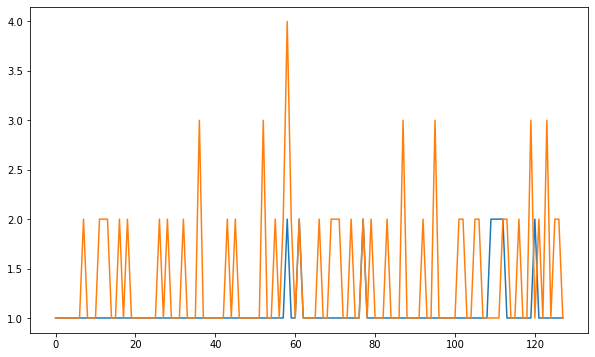

In [77]:
plt.plot(range(0 ,y_pred_peak_sales.shape[0]),y_pred_peak_sales)
plt.plot(range(0 ,p1_peak_sales_test.shape[0]),p1_peak_sales_test)

In [78]:
calender_data['is_event'].iloc[p1_peak_days_test.index].value_counts()

0    119
1      9
Name: is_event, dtype: int64

In [79]:
p1_peak_days_test.shape

(128, 3)

In [80]:
clf.feature_importances_

array([0.40017328, 0.48846639, 0.11136033])

In [81]:
high_sales_p1_days = calender_data[0:p1.shape[0]].loc[p1>1]

In [82]:
high_sales_p1_days.groupby('weekday').count()

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event
weekday,,,,,,,,,,,,,,
Friday,17,17,17,17,17,17,1,1,0,0,17,17,17,17
Monday,15,15,15,15,15,15,3,3,0,0,15,15,15,15
Saturday,32,32,32,32,32,32,2,2,0,0,32,32,32,32
Sunday,21,21,21,21,21,21,2,2,1,1,21,21,21,21
Thursday,12,12,12,12,12,12,1,1,0,0,12,12,12,12
Tuesday,19,19,19,19,19,19,0,0,0,0,19,19,19,19
Wednesday,14,14,14,14,14,14,1,1,0,0,14,14,14,14


Friday and Saturday has high probability of having high sales. We can use weekday with label encoder starting from 
friday

In [83]:
index_high_sales_p1_days =  high_sales_p1_days.index

In [84]:
diff = [index_high_sales_p1_days[i+1] - index_high_sales_p1_days[i] for i in range(0,len(index_high_sales_p1_days)-1)]

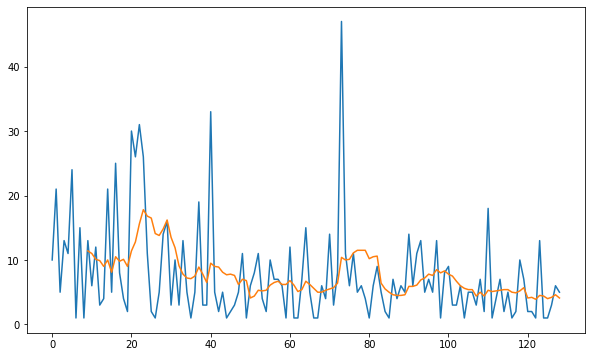

In [85]:
plt.plot(range(0,len(diff)),diff)
plt.plot(range(0,len(diff)),pd.Series(diff).rolling(window = 10).mean())

In [86]:
p1.describe()

count    1913.000000
mean        0.313643
std         0.685250
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: 0, dtype: float64